# The Curse of Conditoning on Colliders

Popular science articles like [this one](https://www.theatlantic.com/business/archive/2012/05/when-correlation-is-not-causation-but-something-much-more-screwy/256918/?utm_source=fbb) point to a statistical phenomenon "conditioning on a collider." Quoting,

> *If a case being observed is a function of two variables then this will induce an artifactual negative correlation  between the variables. This is true even if in the broader population there is no correlation (or even a mild positive correlation) between the variables.*

This notebook will explain some of the math behind this particular kind of selection bias, and explore some consequences. 

## A Simple Case

Let's first consider the simple case presented in the article: We have a population with two traits, both of which are standard-normally distributed ($\mu = 0, \sigma^{2}=1$). Let's say we're looking at stand-up comics, and assume their success depends only on (1) their marketing skill ($m$) and (2) their humor ($h$). We'll define a *selection regime f(m, h)* which is a function of marketing skill and humor. The function returns either $1$ (success) or $0$ (failure) depending on $m, h$. Formally, 

$$m \sim \mathcal{N}(0, 1)$$
$$h \sim \mathcal{N}(0, 1)$$
$$s(m, h) = \begin{cases} 1 &\text{if } m + h \geq 2 \\ 0 &\text{otherwise} \end{cases}$$

Then while there's no actual correlation between humor and marketing skill for all comics, we'll observe a negative correlation between $m, h$ for the successful comics. 

First, let's simulate a dataset of 500 "comics" according to this model. Just as the article, we'll observe a *negative correlation* between humor and marketing skill for the ones that make it.

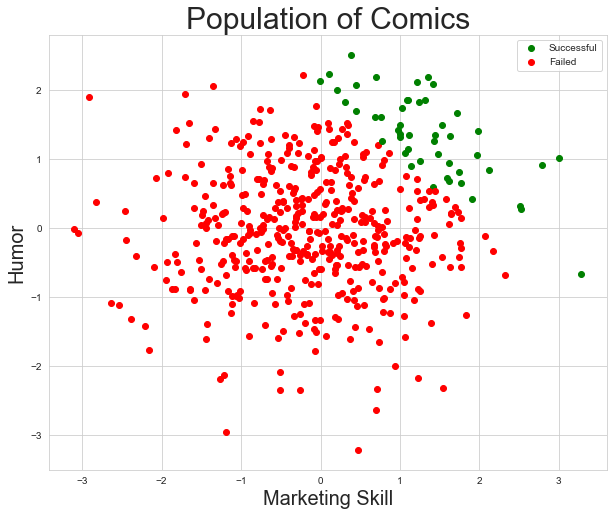

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from collections import OrderedDict
import scipy.stats
%matplotlib inline

import seaborn as sns 
sns.set_style('whitegrid')
# from jupyterthemes import jtplot
# jtplot.style()

# plt.style.use('bmh')


def all_plot(selection_func): 
    fig = plt.figure(figsize=[10, 8])
    ax = plt.subplot()
    all_samples = []
    observed_vals = []
    for _ in range(500): 
        x_val, y_val = np.random.normal(0, 1), np.random.normal(0, 1)
        all_samples.append([x_val, y_val])
        if (selection_regime(x_val, y_val)): 
            observed_vals.append([x_val, y_val])
            ax.scatter(x_val, y_val, color='green', label='Successful')
        else:
            ax.scatter(x_val, y_val, color='red', label='Failed')
    ax.set_xlabel('Marketing Skill', fontsize=20)
    ax.set_ylabel('Humor', fontsize=20)
    ax.set_title('Population of Comics', fontsize=30)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='10')
    return observed_vals

def success_plot(observed_vals):
    fig = plt.figure(figsize=[10, 8])
    ax2 = plt.subplot()
    
    observed_x_vals = [point[0] for point in observed_vals]
    observed_y_vals = [point[1] for point in observed_vals]
    
    for point in observed_vals: 
        ax2.scatter(point[0], point[1], color='green')
        
    #construct a best-fit line
    best_fit_1d = np.polyfit(observed_x_vals, observed_y_vals, deg=1)
    best_fit_func = lambda x: best_fit_1d[1] + (x*best_fit_1d[0])
    
    #plot the best-fit line
    ax2.plot(observed_x_vals, [best_fit_func(x) for x in observed_x_vals], color='green')

    #finding correlation 
    corr = scipy.stats.spearmanr(observed_x_vals, observed_y_vals)
    
    #finalizing the plot
    ax2.set_xlabel('Marketing Skill', fontsize=20)
    ax2.set_ylabel('Humor', fontsize=20)
    ax2.set_title('Successful Comics: Spearman r={}, p={}'.format(round(corr[0], 3), 
                                                                  round(corr[1], 6)), fontsize=20)
    plt.show()

selection_regime = lambda x, y: (x + y) > 2    
observed = all_plot(selection_regime)

Evidently, there's no correlation between marketing skill and humor. But if we only consider the successful comics, we can observe an artifical negative correlation. Making a conservative assumption, let's use the Spearman correlation coefficient, which doesn't assume any underlying distribution of the data. Even then, there's a solid negative correlation.

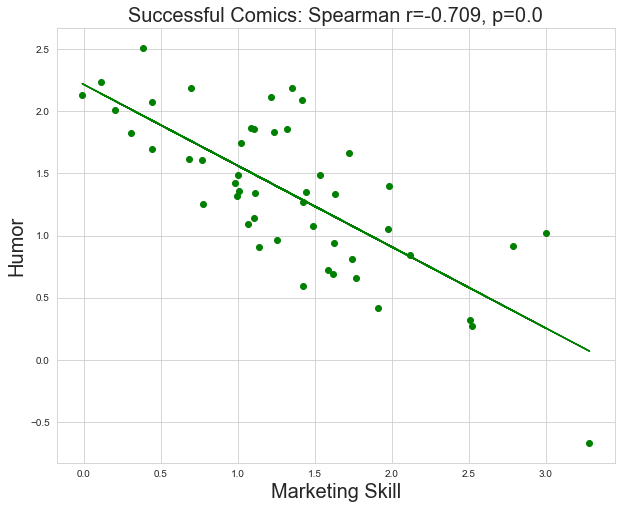

In [3]:
success_plot(observed)

So, when does this happen? Alarmingly often, according the the author. (Emphasis mine)

> Conditioning on a collider can occur any time that there is an underlying selection regime that involves either variables in the dataset or correlates of variables in the dataset. **This is almost inevitable if you have built a composite dataset out of multiple constituent datasets.** That is, a case appears in the sample if it meets one or more sampling criteria. This is actually a fairly common sample design, usually premised on the idea of not wanting to "miss anything" and/or wanting to increase the sample size. 

## More Complex Selection Regimes

In the previous example, the selection regime I used was fairly simple - the comic succeeded if $m + h \geq 2$. Now, I'll try to see if this effect is still present for more complex functions.

### Sufficiency Selection 

Maybe comics only have a chance if their marketing ability is *good enough.* Once a comic reaches a certain level of exposure, their humor determines if they'll make it or not. Formally, 

$$f(m, h) = \begin{cases} 0.7 &\text{if } m \geq 0 \text{ and } h \geq 0 \\ 0 &\text{otherwise} \end{cases}$$


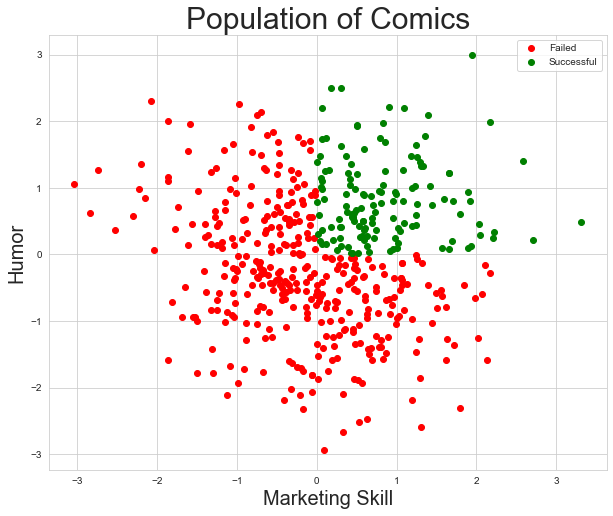

In [4]:
selection_regime = lambda m, h: (m >= 0) and (h >= 0)
observed_vals = all_plot(selection_regime)

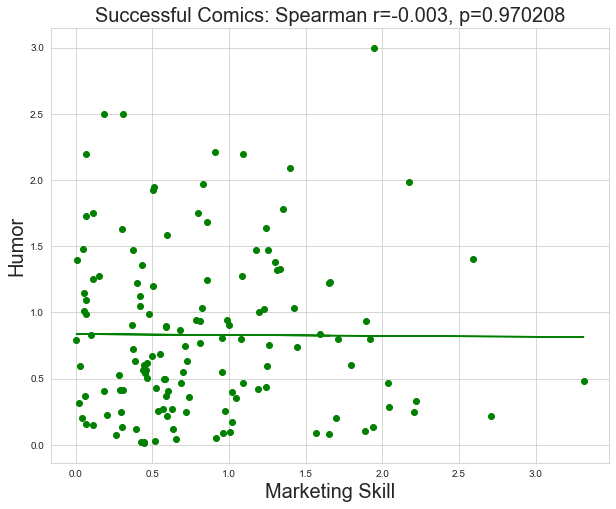

In [5]:
success_plot(observed_vals)

This example turns out to be remarkably different. Mathematically, the reason is that the covariance structure is preserved; the $x, y$ were independent before selection, and should be independent *afterwards*. We can verify this intuition by imposing different cutoffs for $x, y$. 

## Asymmetric Sufficiency Selection

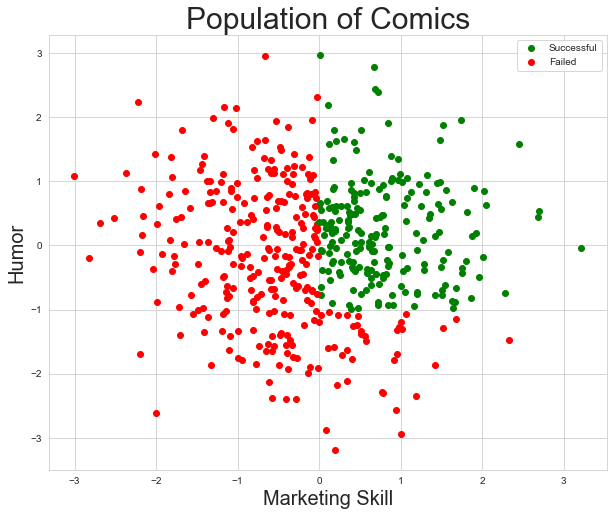

In [10]:
selection_regime = lambda m, h: (m >= 0) and (h >= -1.0)
observed_vals = all_plot(selection_regime)

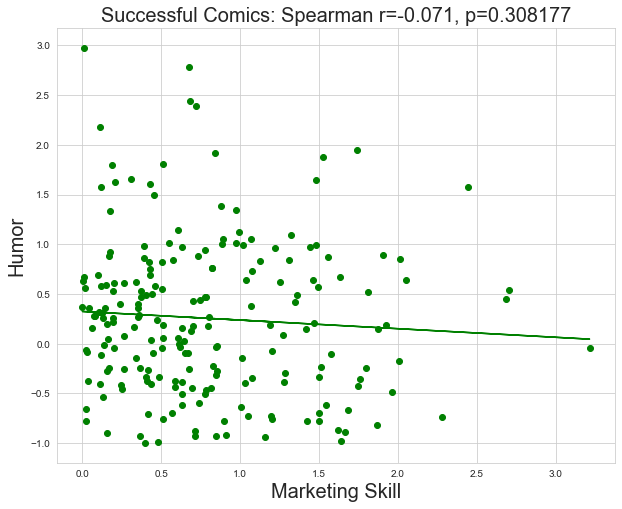

In [11]:
success_plot(observed_vals)

The high $p$-value of $0.3$ indicates that the weak negative correlation we see is not statistically significant anyways. What about higher dimensional sampling? 

# High Dimensional Sampling

In [41]:
from scipy.stats import pearsonr 
def get_pairwise_correlations(data, p_value_cutoff = 0.05): 
    dim = data.shape[-1]
    out_correlations = np.zeros(shape=(dim, dim)) 
    for i in range(dim): 
        for j in range(i): 
            r, p = pearsonr(data[:, i], data[:, j])
            if p <= p_value_cutoff: 
                out_correlations[i, j] = r 
                out_correlations[j, i] = r 
    return out_correlations

In [43]:
def get_filtered_data(n, d): 
    sample = np.random.multivariate_normal(mean = np.zeros(d), cov = np.eye(d), size=n)
    row_sums = np.sum(sample, axis=1)
    threshold = d / 2.0 
    mask = row_sums >= threshold
    return sample[mask]

Let's check for varying dimensions. 

<Axes: title={'center': 'Spurious Correlations for d = 10'}>

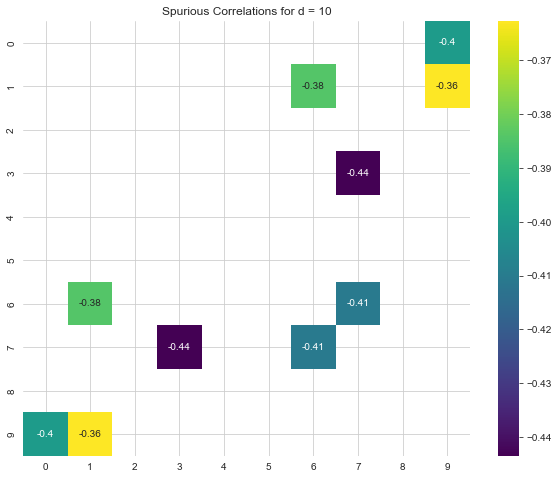

In [49]:
d = 10 
filtered_data = get_filtered_data(500, d)
plt.figure(figsize=[10, 8])
plt.title(f'Spurious Correlations for d = {d}')
corrs = get_pairwise_correlations(filtered_data)
mask = np.abs(corrs) == 0.0 
sns.heatmap(corrs, mask=mask, cmap='viridis', annot=True)

<Axes: title={'center': 'Spurious Correlations for d = 20'}>

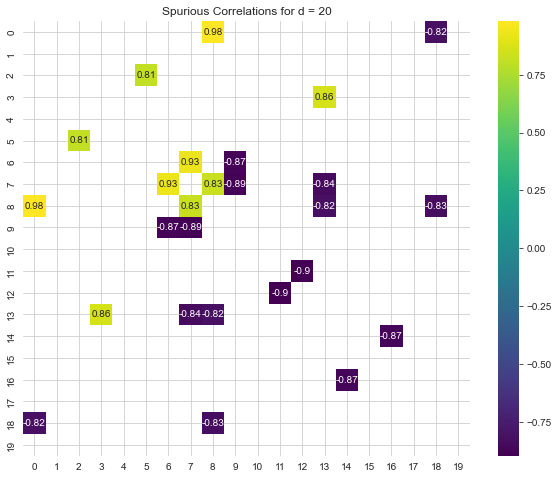

In [50]:
d = 20 
filtered_data = get_filtered_data(500, d)
plt.figure(figsize=[10, 8])
plt.title(f'Spurious Correlations for d = {d}')
corrs = get_pairwise_correlations(filtered_data)
mask = np.abs(corrs) == 0.0 
sns.heatmap(corrs, mask=mask, cmap='viridis', annot=True)

<Axes: title={'center': 'Spurious Correlations for d = 30'}>

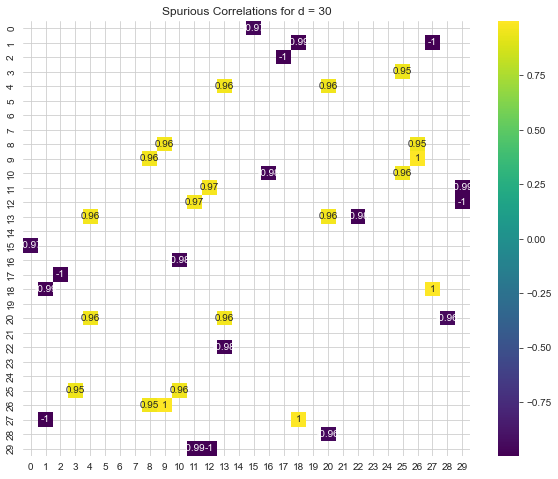

In [51]:
d = 30
filtered_data = get_filtered_data(500, d)
plt.figure(figsize=[10, 8])
plt.title(f'Spurious Correlations for d = {d}')
corrs = get_pairwise_correlations(filtered_data)
mask = np.abs(corrs) == 0.0 
sns.heatmap(corrs, mask=mask, cmap='viridis', annot=True)

We see enormous correlations of, all with $p < 0.05$! What's worse, as $d$ grows, the values of some of these correlations become extremely strong at $0.95$ or above! 

# Conclusion

Conditioning and data merging are ubiquitious in data preprocessing. We've seen that depending on the nature of the underlying distribution and the selection rule, this can induce spurious correlatons. In high dimensional settings, these spurious correlations appear extremely strong and have large $p$-values. This illustrates the importance of careful attention to *every* step of the data pipeline, not just model training.